In [125]:
import os
import sys
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.pdfpage import PDFPage
from pdfminer.converter import XMLConverter, HTMLConverter, TextConverter
from pdfminer.layout import LAParams
import io
import numpy as np 
import sklearn.feature_extraction.text as text
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition
from sklearn.decomposition import NMF, LatentDirichletAllocation


PDF_PATH = os.path.join('data', 'justice','pdfs')
PDF_NAMES = os.listdir(PDF_PATH)
CORPUS_PATH = os.path.join('data','justice','txt')

# CORPUS_PATH = os.path.join('data', 'austen-brontë-split')
# print(PDF_PATH)
# print(PDF_NAMES)
# print(CORPUS_PATH)

#make a list of pdf files names
#go through each of them and write them to the same directory as a text file 

pdffilenames = sorted([os.path.join(PDF_PATH, fn) for fn in os.listdir(PDF_PATH)])
# print(pdffilenames)


def pdfparser(data):

    fp = open(data, 'rb')
    rsrcmgr = PDFResourceManager()
    retstr = io.StringIO()
    codec = 'utf-8'
    laparams = LAParams()
    device = TextConverter(rsrcmgr, retstr, codec=codec, laparams=laparams)
    # Create a PDF interpreter object.
    interpreter = PDFPageInterpreter(rsrcmgr, device)
    # Process each page contained in the document.

    for page in PDFPage.get_pages(fp):
        interpreter.process_page(page)
        data =  retstr.getvalue()

#     print(data)
    return data

# if __name__ == '__main__':
# pdfparser(CORPUS_PATH)  


def pdfConverter(arrayOfFullFileNames, arrayOfPDFNames, destPath):
    for i in range(len(arrayOfFullFileNames)):
#         print(i)
#         print('Creating new text file') 
        if not str(arrayOfPDFNames[i]).startswith('.'):
            name = arrayOfPDFNames[i] + str(i) + '.txt'
#             print(name)
            try:
                content = pdfparser(arrayOfFullFileNames[i])
                contenttwo = str(content)
                finalFile = os.path.join('data','justice','raw', name)
#                 print(finalFile)
                file = open(finalFile,'w')
#                 print(file)
                file.write(str(contenttwo))
                file.close()
            except:
                print('Something went wrong! Can\'t tell what?')
                sys.exit(0) # quit Python
        
        
pdfConverter(pdffilenames,PDF_NAMES,CORPUS_PATH) 


In [126]:
#now delete dot files from that directory for cleanup
# arrayOfFiles = 
# textFiles = sorted([os.path.join(CORPUS_PATH, fn) for fn in os.listdir(CORPUS_PATH)])

# for i in range(len(textFiles)):
#     print(textFiles)
#     print(i)
#     print(textFiles[i])
#     if not str(textFiles[i]).startswith('.'):
#         print(i)
#         print(textFiles[i])
    #   filenames = sorted([os.path.join(CORPUS_PATH, fn) for fn in os.listdir(CORPUS_PATH)])

In [127]:
filenames = sorted([os.path.join(CORPUS_PATH, fn) for fn in os.listdir(CORPUS_PATH)])
# print(filenames)
# print(len(filenames))

In [128]:
vectorizer = text.CountVectorizer(input='filename', stop_words='english', min_df=5, max_df = 0.50)

In [129]:
# print(filenames)
# print(text.CountVectorizer())
# print(vectorizer)
dtm = vectorizer.fit_transform(filenames).toarray()
# print(dtm)
vocab = np.array(vectorizer.get_feature_names())
# print(vocab)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)
CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='filename',
        lowercase=True, max_df=0.5, max_features=None, min_df=5,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)


In [130]:
print(len(vocab))
# print(vectorizer)
print(dtm)

3611
CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='filename',
        lowercase=True, max_df=0.5, max_features=None, min_df=5,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)
[[2 0 0 ..., 0 0 0]
 [1 0 0 ..., 0 0 2]
 [1 0 0 ..., 0 0 0]
 ..., 
 [0 2 0 ..., 0 0 0]
 [0 2 0 ..., 0 0 0]
 [0 2 0 ..., 0 0 0]]


In [131]:
dtm.shape

(115, 3611)

In [144]:
num_topics = 20
num_top_words = 10
clf = decomposition.NMF(n_components=num_topics, random_state=1)

print(clf)

NMF(alpha=0.0, beta=1, eta=0.1, init=None, l1_ratio=0.0, max_iter=200,
  n_components=20, nls_max_iter=2000, random_state=1, shuffle=False,
  solver='cd', sparseness=None, tol=0.0001, verbose=0)


In [133]:
doctopic = clf.fit_transform(dtm)

In [134]:
topic_words = []
for topic in clf.components_:
    word_idx = np.argsort(topic)[::-1][0:num_top_words]
    topic_words.append([vocab[i] for i in word_idx])

# print(topic_words)

In [135]:
doctopic = doctopic / np.sum(doctopic, axis=0, keepdims=True)

In [136]:
document_names = [] 

for fn in filenames:
    basename = os.path.basename(fn)
    name, ext = os.path.splitext(basename)
    name = name.rstrip('0123456789')
    document_names.append(name)
# print(document_names)

In [137]:
document_names = np.asarray(document_names)
doctopic_orig = doctopic.copy()
num_groups = len(set(document_names))
# print(num_groups)
# print(doctopic.copy)
doctopic_grouped = np.zeros((num_groups, num_topics))

# print(doctopic_grouped)

# for i, name in enumerate(sorted(set(document_names))):
#     doctopic_grouped[i, :] = np.mean(doctopic[document_names == name, :], axis=0)

#     doctopic = doctopic_grouped

documents = sorted(set(document_names))
# print(documents)
# print(doctopic)

top_four_topics_total = []

for i in range(len(doctopic)):
    top_topics = np.argsort(doctopic[i,:])[::-1][0:3]
    top_topics_str = ' '.join(str(t) for t in top_topics)
    print("{}: {}".format(documents[i], top_topics_str))
    print(i)
    print(top_topics_str)
    top_topics_split = top_topics_str.split(' ')
    print(top_topics_split)
    top_four_topics_total.extend(top_topics_split)


15-0100 (Nonprofit Hospital Pay).pdf: 7 18 16
0
7 18 16
['7', '18', '16']
15-0101 (Affordable Healthcare).pdf: 16 15 7
1
16 15 7
['16', '15', '7']
15-0102 (Nonprofit Hospital Healthcare).pdf: 16 17 2
2
16 17 2
['16', '17', '2']
15-0103 (Marijuana)_1.pdf: 4 17 16
3
4 17 16
['4', '17', '16']
15-0104 (Marijuana)_0.pdf: 17 11 15
4
17 11 15
['17', '11', '15']
15-0105 (Minimum Wage)_0.pdf: 12 19 8
5
12 19 8
['12', '19', '8']
15-0106 (Sales Tax on Political Advertisements V2).pdf: 17 13 19
6
17 13 19
['17', '13', '19']
15-0107 (Redirect HighSpeed Rail Funds to Water Projects)_0.pdf: 10 15 2
7
10 15 2
['10', '15', '2']
15-0108 (Electronic Voting)_0.pdf: 13 3 15
8
13 3 15
['13', '3', '15']
15-0109 (High Speed Rail)_0.pdf: 10 17 19
9
10 17 19
['10', '17', '19']
15-0110 (Construction-Related Accessibility Claims)_0.pdf: 15 12 19
10
15 12 19
['15', '12', '19']
15-0111 (Hospital Pay)_0.pdf: 7 13 17
11
7 13 17
['7', '13', '17']
15-0112 (Secret Ballot).pdf: 19 10 3
12
19 10 3
['19', '10', '3']
15-011

IndexError: list index out of range

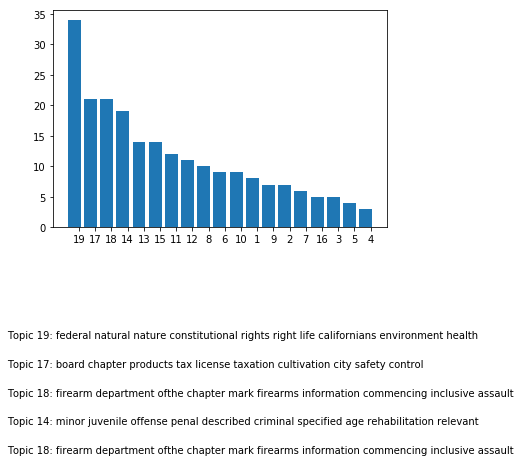

In [138]:
#make a histogram of this all
# print(top_four_topics_total)
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from pylab import *

#make a giant array of top topics for all the documents
counts = Counter(top_four_topics_total)

labels, values = zip(*counts.items())

indSort = np.argsort(values)[::-1]

# rearrange 
labels = np.array(labels)[indSort]
values = np.array(values)[indSort]

indexes = np.arange(len(labels))

bar_width = 0.3

plt.bar(indexes, values)

# add labels
plt.xticks(indexes + bar_width, labels)

figtext(.02, -0.3, "Topic 19: federal natural nature constitutional rights right life californians environment health\n")
figtext(.02, -0.4, "Topic 17: board chapter products tax license taxation cultivation city safety control\n")
figtext(.02, -0.5, "Topic 18: firearm department ofthe chapter mark firearms information commencing inclusive assault\n")
figtext(.02, -0.6, "Topic 14: minor juvenile offense penal described criminal specified age rehabilitation relevant\n")
figtext(.02, -0.7, "Topic 18: firearm department ofthe chapter mark firearms information commencing inclusive assault\n")


plt.show()

In [139]:
for t in range(len(topic_words)):
    print("Topic {}: {}".format(t, ' '.join(topic_words[t][:20])))

Topic 0: vehicle department program violation date fee 21 page 05 rn
Topic 1: property replacement value original dwelling base claimant paragraph date transfer
Topic 2: water projects division funds dollars agency million chapter project fund
Topic 3: mail voter official electronic commission ofthe submission secure voting security
Topic 4: marijuana division products department tax licensing health cultivation bureau chapter
Topic 5: vehicle tax transportation department program funds fiscal fuel fund revenues
Topic 6: information consumer personal business 1798 commercial privacy consumers civil sell
Topic 7: hospital compensation medical corporation entity covered group nonprofit executive affiliated
Topic 8: water projects available funds division million dollars resources natural communities
Topic 9: chronic department patient ofthe governing entity care health patients treatment
Topic 10: water authority storage chapter bonds 15 project facilities groundwater division
Topic 11: 

In [157]:
#try to display topics with context
def display_topics(H, W, feature_names, documents, no_top_words, no_top_documents):
    for topic_idx, topic in enumerate(H):
        print('Topic')
        print(topic_idx)
        print (" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        top_doc_indices = np.argsort( W[:,topic_idx] )[::-1][0:no_top_documents]
        for doc_index in top_doc_indices:
            print(documents[doc_index])

            
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=1000, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(filenames)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()


nmf_model = clf.fit(tfidf)
nmf_W = nmf_model.transform(tfidf)
nmf_H = nmf_model.components_


tf_vectorizer = vectorizer
tf = tf_vectorizer.fit_transform(filenames)
tf_feature_names = tf_vectorizer.get_feature_names()

no_topics = 20


no_top_words = 8
no_top_documents = 4
display_topics(nmf_H, nmf_W, tfidf_feature_names, filenames, no_top_words, no_top_documents)


Topic
0
0034 revenue bond tax 17 pdf7 pdf6 pdf34
data/justice/txt/17-0034 (Tax and Bond Revenue).pdf72.txt
data/justice/txt/17-0034 (Tax and Bond Revenue)_0.pdf73.txt
data/justice/txt/17-0034 (Tax and Bond Revenue).pdf6.txt
data/justice/txt/17-0034 (Tax and Bond Revenue).pdf34.txt
Topic
1
gas car 0033 tax _0 repeal 0004 17
data/justice/txt/17-0033 (Gas and Car Tax)_0.pdf71.txt
data/justice/txt/17-0033 (Gas and Car Tax)_0.pdf33.txt
data/justice/txt/17-0033 (Gas and Car Tax)_0.pdf5.txt
data/justice/txt/17-0004 (Repeal Gas Tax)_0.pdf42.txt
Topic
2
quot 16 referendum ab sb pdf35 pdf30 pdf32
data/justice/txt/16-0010 (&quot;Referendum on AB 857&quot;).pdf36.txt
data/justice/txt/16-0004 (&quot;Referendum on AB 1135&quot;).pdf30.txt
data/justice/txt/16-0009 (&quot;Referendum on AB 1511&quot;).pdf35.txt
data/justice/txt/16-0007 (&quot;Referendum on SB 880&quot;).pdf33.txt
Topic
3
15 marijuana _0 accessibility hospital rail pdf24 pay
data/justice/txt/15-0104 (Marijuana)_0.pdf5.txt
data/justice/t